# Outlier Detector for Cifar10 model with Poetry-defined Environment

## Prerequisites

 * A kubernetes cluster with kubectl configured
 * poetry
 * rclone
 * curl

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core). Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html).

We will assume that ambassador (or Istio) ingress is port-forwarded to `localhost:8003`

In [1]:
!kubectl create namespace cifar10 || true

namespace/cifar10 created


## Setup MinIO

Use the provided [notebook](https://docs.seldon.io/projects/seldon-core/en/latest/examples/minio_setup.html) to install Minio in your cluster.
Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/minio_setup.html).

We will assume that MinIO service is port-forwarded to `localhost:8090`

In [2]:
%%writefile rclone.conf
[s3]
type = s3
provider = minio
env_auth = false
access_key_id = minioadmin
secret_access_key = minioadmin
endpoint = http://localhost:8090

Overwriting rclone.conf


In [3]:
%%writefile secret.yaml
apiVersion: v1
kind: Secret
metadata:
  name: seldon-rclone-secret
  namespace: cifar10
type: Opaque
stringData:
  RCLONE_CONFIG_S3_TYPE: s3
  RCLONE_CONFIG_S3_PROVIDER: minio
  RCLONE_CONFIG_S3_ENV_AUTH: "false"
  RCLONE_CONFIG_S3_ACCESS_KEY_ID: minioadmin
  RCLONE_CONFIG_S3_SECRET_ACCESS_KEY: minioadmin
  RCLONE_CONFIG_S3_ENDPOINT: http://minio.minio-system.svc.cluster.local:9000

Overwriting secret.yaml


In [4]:
!kubectl apply -f secret.yaml

secret/seldon-rclone-secret created


## Poetry

We will use `poetry.lock` to fully define the explainer environment. Install poetry following official [documentation](https://python-poetry.org/docs/#installation). Usually this goes down to
```bash
curl -sSL https://raw.githubusercontent.com/python-poetry/poetry/master/get-poetry.py | python3 -
```

# Train Outlier Detector

## Prepare Training Environment

We are going to use `pyproject.toml` and `poetry.lock` files from [Alibi Detect Server](https://github.com/SeldonIO/seldon-core/tree/master/components/alibi-detect-server). This will allow us to create environment that will match the runtime one.

Currently, the server's pyproject.toml is structured in the way that it uses a locally present source code of seldon-core.

Please, make sure that you obtain the source code that match the version of used alibi-detect-server. 

In [5]:
%%bash
cp ../../../components/alibi-detect-server/pyproject.toml .
cp ../../../components/alibi-detect-server/poetry.lock .

(rm _seldon_core -rf || true) && cp -rT ../../../python/ _seldon_core/

conda create --yes --prefix ./venv python=3.7.10

Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/rskolasinski/work/seldon-core/examples/outliers/cifar10-od-poetry/venv

  added / updated specs:
    - conda-ecosystem-user-package-isolation
    - python=3.7.10


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-1_gnu
  ca-certificates    conda-forge/linux-64::ca-certificates-2021.10.8-ha878542_0
  conda-ecosystem-u~ conda-forge/linux-64::conda-ecosystem-user-package-isolation-1.0-ha770c72_1
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.36.1-hea4e1c9_2
  libffi             conda-forge/linux-64::libffi-3.4.2-h7f98852_5
  libgcc-ng          conda-forge/linux-64::libgcc-ng-11.2.0-h1d223b6_15
  libgomp            conda-forge/linux-64:

In [6]:
%%bash
source ~/miniconda3/etc/profile.d/conda.sh
conda activate ./venv
poetry install

Installing dependencies from lock file

Package operations: 169 installs, 0 updates, 0 removals

  • Installing certifi (2021.10.8)
  • Installing charset-normalizer (2.0.12)
  • Installing idna (3.3)
  • Installing pyasn1 (0.4.8)
  • Installing urllib3 (1.26.5)
  • Installing cachetools (4.2.4)
  • Installing oauthlib (3.2.0)
  • Installing protobuf (3.19.4)
  • Installing pyasn1-modules (0.2.8)
  • Installing pycparser (2.21)
  • Installing pyparsing (3.0.7)
  • Installing rsa (4.7.2)
  • Installing six (1.16.0)
  • Installing typing-extensions (4.1.1)
  • Installing zipp (3.7.0)
  • Installing requests (2.27.1)
  • Installing cffi (1.15.0)
  • Installing google-auth (1.35.0)
  • Installing googleapis-common-protos (1.56.0)
  • Installing importlib-metadata (4.11.3)
  • Installing markupsafe (1.1.1)
  • Installing packaging (21.3)
  • Installing pytz (2022.1)
  • Installing requests-oauthlib (1.3.1)
  • Installing absl-py (1.0.0)
  • Installing azure-common (1.1.28)
  • Installing ca

## Prepare Training Script

In [7]:
%%writefile train.py
import logging
import os

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Flatten, Layer, Reshape, InputLayer
from tensorflow.keras.regularizers import l1

from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector


logger = tf.get_logger()
logger.setLevel(logging.ERROR)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierVAE'

# define encoder and decoder networks
latent_dim = 1024
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
  ]
)

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(latent_dim,)),
      Dense(4*4*128),
      Reshape(target_shape=(4, 4, 128)),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ]
)

# initialize outlier detector
od = OutlierVAE(
    threshold=.015,  # threshold for outlier score
    encoder_net=encoder_net,  # can also pass VAE model instead
    decoder_net=decoder_net,  # of separate encoder and decoder
    latent_dim=latent_dim
)

# train
od.fit(X_train, epochs=50, verbose=True)

# save the trained outlier detector
save_detector(od, './outlier-detector')

Overwriting train.py


In [8]:
%%time
!./venv/bin/python3 train.py

2022-04-14 13:41:54.199577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:41:54.217047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:41:54.217420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 13:41:54.217938: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
!tree outlier-detector

outlier-detector
├── meta.dill
├── model
│   ├── checkpoint
│   ├── decoder_net.h5
│   ├── encoder_net.h5
│   ├── vae.ckpt.data-00000-of-00001
│   └── vae.ckpt.index
└── OutlierVAE.dill

1 directory, 7 files


## Deploy Cifar10 model and Outlier Detector

Note, this requires Knative. Follow Knative [documentation](https://knative.dev/docs/install/) to install it.

In [10]:
!rclone --config="rclone.conf" copy outlier-detector/ s3:outlier-detector/cifar10/

### Deploy Event Display

In [11]:
%%writefile event-display.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: event-display
  namespace: cifar10
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: event-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
       - name: event-display
         image: gcr.io/knative-releases/knative.dev/eventing-contrib/cmd/event_display

---

kind: Service
apiVersion: v1
metadata:
  name: event-display
  namespace: cifar10
spec:
  selector:
    app: event-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080

Overwriting event-display.yaml


In [12]:
!kubectl apply -f event-display.yaml

deployment.apps/event-display created
service/event-display created


### Deploy Model

In [13]:
%%writefile cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
  namespace: cifar10
spec:
  protocol: tensorflow
  predictors:
  - name: default
    replicas: 1
    graph:
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: cifar10-container
      logger:
        mode: all    
        url: http://broker-ingress.knative-eventing.svc.cluster.local/cifar10/default

Overwriting cifar10.yaml


In [14]:
!kubectl apply -f cifar10.yaml

seldondeployment.machinelearning.seldon.io/cifar10 created


### Create Knative Broker, Trigger and Kservice

In [15]:
%%writefile broker.yaml

apiVersion: eventing.knative.dev/v1
kind: broker
metadata:
 name: default
 namespace: cifar10

Overwriting broker.yaml


In [16]:
!kubectl create -f broker.yaml

broker.eventing.knative.dev/default created


In [17]:
%%writefile kservice.yaml
apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: vae-outlier
  namespace: cifar10
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:1.14.0-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10od
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - s3:outlier-detector/cifar10
        - --reply_url
        - http://event-display.cifar10.svc.cluster.local
        - --event_type
        - io.seldon.serving.inference.outlier
        - --event_source
        - io.seldon.serving.cifar10od
        - OutlierDetector
        envFrom:
        - secretRef:
            name: seldon-rclone-secret

Overwriting kservice.yaml


In [18]:
!kubectl apply -f kservice.yaml

service.serving.knative.dev/vae-outlier created


In [19]:
%%writefile trigger.yaml
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: vaeoutlier-trigger
  namespace: cifar10
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: vae-outlier
      namespace: cifar10

Overwriting trigger.yaml


In [20]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/vaeoutlier-trigger created


## Test it!

In a terminal follow logs of the `event-display` deployment with for example
```bash
kubectl logs event-display-7f5f8647fb-t227z -f
```

Now we were send two requests, one containing a normal image and one outlier.

Note: it may take a moment for the kservice to become available

In [22]:
%%bash
deployment=$(kubectl get deploy -n cifar10 -l seldon-deployment-id=cifar10 -o jsonpath='{.items[0].metadata.name}')
kubectl rollout status deploy/${deployment} -n cifar10

deployment "cifar10-default-0-cifar10-container" successfully rolled out


In [23]:
!kubectl get broker,trigger,kservice -n cifar10

NAME                                  URL                                                                        AGE   READY   REASON
broker.eventing.knative.dev/default   http://broker-ingress.knative-eventing.svc.cluster.local/cifar10/default   5m    True    

NAME                                              BROKER    SUBSCRIBER_URI                                 AGE     READY   REASON
trigger.eventing.knative.dev/vaeoutlier-trigger   default   http://vae-outlier.cifar10.svc.cluster.local   4m59s   True    

NAME                                      URL                                      LATESTCREATED       LATESTREADY         READY   REASON
service.serving.knative.dev/vae-outlier   http://vae-outlier.cifar10.example.com   vae-outlier-00001   vae-outlier-00001   True    


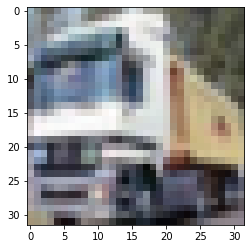

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


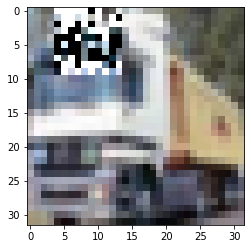

In [24]:
import json

import matplotlib.pyplot as plt

with open("images/cifar10_image.json") as f:
    data = json.load(f)
plt.imshow(data["instances"][0])
plt.show()

with open("images/outlier_image.json") as f:
    data = json.load(f)
plt.imshow(data["instances"][0])
plt.show();

In [25]:
%%bash
curl -s -H "Content-Type: application/json" -d @images/cifar10_image.json http://localhost:8003/seldon/cifar10/cifar10/v1/models/:predict | jq .
curl -s -H "Content-Type: application/json" -d @images/outlier_image.json http://localhost:8003/seldon/cifar10/cifar10/v1/models/:predict | jq .

{
  "predictions": [
    [
      1.26448288e-06,
      4.88144e-09,
      1.51532642e-09,
      8.49054249e-09,
      5.51306611e-10,
      1.16171261e-09,
      5.77286274e-10,
      2.88394716e-07,
      0.00061489339,
      0.999383569
    ]
  ]
}
{
  "predictions": [
    [
      0.000593999459,
      1.13762019e-06,
      9.31399063e-06,
      4.24927e-05,
      2.75517505e-06,
      3.1435934e-06,
      1.53180349e-06,
      2.40643985e-05,
      0.320169568,
      0.679151952
    ]
  ]
}


In [26]:
%%bash
pod=$(kubectl get pod -n cifar10 -l app=event-display -o jsonpath='{.items[0].metadata.name}')
kubectl logs $pod -n cifar10

☁️  cloudevents.Event
Validation: valid
Context Attributes,
  specversion: 1.0
  type: io.seldon.serving.inference.outlier
  source: io.seldon.serving.cifar10od
  id: 10a3afa3-cff0-4635-ae9f-228a4606d4c4
  datacontenttype: application/json
Extensions,
  datacontenttype: application/json
  endpoint: default
  inferenceservicename: cifar10
  knativearrivaltime: 2022-04-14T13:39:51.246502704Z
  modelid: cifar10-container
  namespace: cifar10
  requestid: b1dd7f60-af19-4923-8798-fe0a59917f03
  traceparent: 00-96072a87694e76ba19866ae817338065-36d85cff2f7e96ed-00
Data,
  {
    "data": {
      "is_outlier": [
        0
      ]
    },
    "meta": {
      "name": "OutlierVAE",
      "detector_type": "offline",
      "data_type": null,
      "version": "0.9.0"
    }
  }
☁️  cloudevents.Event
Validation: valid
Context Attributes,
  specversion: 1.0
  type: io.seldon.serving.inference.outlier
  source: io.seldon.serving.cifar10od
  id: 9f01ad25-f9e0-4dde-b44b-4195f0215e7b
  datacontenttype: applic

## Tear Down

In [27]:
!kubectl delete ns cifar10

namespace "cifar10" deleted
